Dashboard Intéractif

In [4]:
# %% [markdown]
"""
# Analyse Exploration des Données - Campagnes Commerciales
**Auteur**: Votre nom  
**Date**: DD/MM/YYYY  
**Objectif** : Identifier les leviers d'optimisation des campagnes d'appels
"""
# %%
# %% [markdown]
## 1. Chargement et Inspection des Données
# %%
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

df = pd.read_csv('../data/campaign_data.csv', parse_dates=['call_datetime'])
df['converted'] = df['converted'].astype(bool)

print(f"Dimensions des données : {df.shape}")
display(df.head(3))


Dimensions des données : (97767, 14)


,call_id,call_datetime,call_time,call_hour,duration,product,region,city,agent_id,agent_tier,client_type,previous_contacts,converted,campaign_boost
0,652a7a54-d3d7-49c7-8dc0-00b68c18d386,2024-01-01 10:01:35,10:01:35,10,444.0,Hardware,North,Chicago,38ce84d2-3c9a-4552-a728-e11cdc7f5cdc,expert,startup,1,True,0.0
1,f5ecd0a4-1a1e-4643-8e8e-c0f09df49748,2024-01-01 11:24:06,11:24:06,11,127.0,SaaS,West,Atlanta,6ed491dc-e627-4c44-92d0-f40debd365c0,expert,startup,3,False,0.0
2,1ca90695-51f7-4593-86fb-215efb98c2f5,2024-01-01 15:45:04,15:45:04,15,139.0,Hardware,West,San Diego,c99fbe1b-0188-4412-8a2a-7224231e62f8,intermediate,startup,1,True,0.0


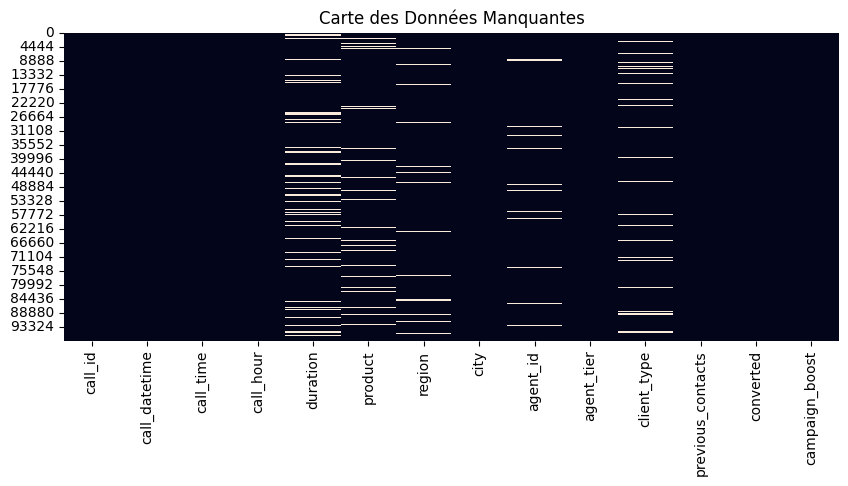

,Type,Missing (%),Unique Values,Sample Values
call_id,object,0.00,97767,"[652a7a54-d3d7-49c7-8dc0-00b68c18d386, f5ecd0a..."
call_datetime,datetime64[ns],0.00,96707,"[2024-01-01 10:01:35, 2024-01-01 11:24:06, 202..."
call_time,object,0.00,32129,"[10:01:35, 11:24:06, 15:45:04]"
call_hour,int64,0.00,13,"[10, 11, 15]"
duration,float64,15.04,1689,"[444.0, 127.0, 139.0]"
product,object,9.98,4,"[Hardware, SaaS, Consulting]"
region,object,4.91,4,"[North, West, South]"
city,object,0.00,20,"[Chicago, Atlanta, San Diego]"
agent_id,object,1.98,101,"[38ce84d2-3c9a-4552-a728-e11cdc7f5cdc, 6ed491d..."
agent_tier,object,0.00,3,"[expert, intermediate, novice]"


In [5]:

# %% [markdown]
## 2. Data Quality Check (Automatisé)
# %%
def data_quality_report(df):
    report = pd.DataFrame({
        'Type': df.dtypes,
        'Missing (%)': (df.isnull().mean() * 100).round(2),
        'Unique Values': df.nunique(),
        'Sample Values': [df[col].unique()[:3] for col in df.columns]
    })
    
    # Visualisation des valeurs manquantes
    plt.figure(figsize=(10, 4))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title('Carte des Données Manquantes')
    plt.show()
    
    return report

dq_report = data_quality_report(df)
display(dq_report)


In [ ]:

# %% [markdown]
## 3. Analyse des Taux de Conversion
# %%
# Configuration globale
plt.style.use('ggplot')
conv_palette = ['#FF6B6B', '#4ECDC4']

# %% [markdown]
### 3.1 Répartition Globale
# %%
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
df['converted'].value_counts().plot.pie(
    autopct='%1.1f%%', colors=conv_palette, ax=ax[0],
    title='Répartition Conversions', labels=['Non Converti', 'Converti']
)

# Distribution temporelle
sns.histplot(data=df, x='call_time', hue='converted', 
             multiple='stack', palette=conv_palette, ax=ax[1])
ax[1].set_title('Volume d\'Appels par Heure')
plt.tight_layout()

# %% [markdown]
### 3.2 Analyse Multidimensionnelle
# %%
def plot_interactive_sunburst():
    fig = px.sunburst(
        df,
        path=['region', 'product'],
        values='duration',
        color='converted',
        color_continuous_scale=conv_palette,
        title='Répartition Hiérarchique des Conversions'
    )
    fig.update_layout(margin=dict(t=40, l=0, r=0, b=0))
    fig.show()

plot_interactive_sunburst()

C:\Users\ibrah\AppData\Local\Temp\ipykernel_5260\1409505330.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


ValueError: ('None entries cannot have not-None children', ('East', 'Hardware'))

Error in callback <function _draw_all_if_interactive at 0x000002231F0D8A60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
# %% [markdown]
## 4. Analyse Temporelle Avancée
# %%
# Agrégation quotidienne
daily_data = df.groupby('call_date').agg(
    total_calls=('call_id', 'count'),
    conversion_rate=('converted', 'mean')
).reset_index()

# Découpage des tendances
result = seasonal_decompose(daily_data['conversion_rate'], model='additive', period=7)
fig = result.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Décomposition des Taux de Conversion (Tendances Saisonnières)')
plt.tight_layout()



In [ ]:
# %% [markdown]
## 5. Tests Statistiques
# %%
# Test ANOVA entre scripts
script_groups = [group['converted'].values for name, group in df.groupby('script_version')]
f_val, p_val = stats.f_oneway(*script_groups)

print(f"""
🔍 Résultats des Tests Statistiques :
- ANOVA entre scripts : F-value = {f_val:.2f}, p-value = {p_val:.3f}
- Test t heures de pic vs non-pic : {stats.ttest_ind(
    df[df['call_time'].between(14,16)]['converted'],
    df[~df['call_time'].between(14,16)]['converted']
)}
""")



In [ ]:
# %% [markdown]
## 6. Analyse des Performances par Script
# %%
# Heatmap interactive
script_perf = df.pivot_table(
    index='script_version',
    columns='call_time',
    values='converted', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(script_perf, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Taux de Conversion par Script et Heure')
plt.xlabel('Heure de l\'Appel')
plt.ylabel('Version du Script')



In [ ]:
# %% [markdown]
## 7. Recommandations Actionnables
# %%
# Calcul des meilleures combinaisons
best_combinations = df.groupby(['script_version', 'call_time', 'product']).agg(
    conversion_rate=('converted', 'mean'),
    volume=('call_id', 'count')
).sort_values('conversion_rate', ascending=False).head(5)

print("Top 5 des Combinaisons Performantes :")
display(best_combinations.style.format({
    'conversion_rate': '{:.1%}',
    'volume': '{:,}'
}).background_gradient(cmap='Blues'))


In [ ]:

# %% [markdown]
## 8. Export des Insights
# %%
# Génération automatique de slides
from pptx import Presentation
from pptx.util import Inches

prs = Presentation()
slide = prs.slides.add_slide(prs.slide_layouts[5])

# Ajout du titre
title = slide.shapes.title
title.text = "Principaux Insights - Campagnes Commerciales"

# Ajout d'un graphique
img_path = 'conversion_heatmap.png'
plt.savefig(img_path, bbox_inches='tight')
left = top = Inches(1)
slide.shapes.add_picture(img_path, left, top, height=Inches(4.5))

prs.save('campaign_insights.pptx')